# Apply KNN on Amazon fine food reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given the Amazon fine food review dataset, apply time based splitting of the reviews. Make 70% of them as Train dataset and remaining as Test dataset.
Apply 10-fold cross validation on Train dataset to find K for K-NN. Find Test accuracy of Test data and confusion matrix. Use BoW, TF-IDF, Avg-Word2Vec, TF-IDF-Word2Vec to vectorise the reviews.

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#getting the dataset into a dataframe 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews where ProfileName like 'e%' and Score != 3 order by Time
""", con) 
#filtering data to a limited set for fast computing
#sorting the data on the basis of timestamp for time based spliting of Dtrain and Dtest

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['positiveNegative'] = positiveNegative # adding a new column 'positiveNegative' to the dataset


In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positiveNegative
0,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,positive
1,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,5,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,positive
2,446351,B0000YVCI0,A7V64BJ4FANV2,Emma R. Brashars,0,0,5,1077494400,You HAVE to try these,If you haven't tried these you need to now!<p>...,positive
3,163149,B00015UC8E,A20UAWANPNGCLY,"E. Funk ""dfunke1""",5,6,5,1081468800,Barry Farms,"Great product great service, fast shipping. Ve...",positive
4,40041,B0000DG4MO,A1R91I3D97CMYX,Exxxxx,3,3,5,1085356800,HOTHOTHOTHOTHOTHOTHOT,This hot sauce is no joke. I've loved spicy f...,positive


##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(11115, 11)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

72.44818146265153

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['positiveNegative'].value_counts()
print(type(final))

(11115, 11)
<class 'pandas.core.frame.DataFrame'>


## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
        i += 1;  

   

0
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [11]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))


{'wouldn', 'his', 'doing', 'each', "couldn't", 'her', 'were', 'couldn', 'am', 'too', 'the', 'she', 'y', 'just', 'an', "isn't", 'having', 'them', 'of', 'herself', 'how', 'mightn', 'as', 'more', 'you', 'mustn', 'few', 'is', 'had', 'about', 'will', "you'd", "don't", 'from', 've', 'hadn', 'above', 'myself', 'they', 'during', 'yours', 'on', 'doesn', 'to', 'in', 'isn', 'what', 'own', 'than', 'themselves', 'other', 'ma', 'there', 're', 'up', "you've", 'be', 't', 'my', "doesn't", 'now', 'theirs', 'whom', 'have', 'he', 'once', 'your', 'or', "hasn't", "you're", 'don', 'does', 'didn', 'again', 'so', 'those', 'where', 'most', 'me', "you'll", 'hers', "wasn't", 'below', 'off', 'who', 'should', 'i', 'wasn', 'under', "haven't", 'further', 'needn', 'a', 'aren', 'this', 'itself', 'same', 'by', 'after', 'with', 'm', 'very', 'was', 'but', "shan't", "didn't", 'are', 'their', 'did', 'nor', 'then', "aren't", 'won', 'some', "weren't", 'o', "hadn't", 'only', 'him', 'into', 'through', "that'll", 'because', 'for

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanhtml(cleanpunc(w)).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    #check whether the word is alphabatic or not+ length of the word is >2 or not
                if(cleaned_words.lower() not in stop): #checking whether the word belongs to stopword or not
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['positiveNegative'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['positiveNegative'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    #print(str1)
    #print("***********************************************************************")
    i+=1
#print(final_string)

print(type(final_string))

<class 'list'>


In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [14]:
import csv
final.head(3) #below the processed review can be seen in the CleanedText Column 
final.to_csv('hmmm.csv')

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [15]:
final.head()
#print(type(final))

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positiveNegative,CleanedText
3248,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,5,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...,positive,b'ive alway love chicken soup rice late ethel ...
14,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,4,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,positive,b'young boy describ use chicken soup rice mont...
13,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""...",positive,b'day person say chicken soup theyr probabl go...
6997,171117,7310172001,A2QXPFTACXWV1I,Ellie at Round Pond,0,0,5,1302825600,Liver treats,My dog is not enthusiastic about food. She en...,positive,b'dog enthusiast food enjoy treat light weight...
12553,171254,7310172001,A3MU6WPG4R7XIB,"Elinor Stickney ""mystery lover""",0,0,5,1337644800,Loves liver treats,These Stewarts Liver treats are the love of my...,positive,b'stewart liver treat love wirehair dachshund ...


# Bag of Words (BoW)

In [16]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
#print(type(count_vect))
final_counts = count_vect.fit_transform(final['CleanedText'].values)
#X=final_counts.toarray() 
Y= final['positiveNegative'].tolist()

In [17]:
print(type(final_counts))
print(type(Y))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'list'>


In [18]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# =============================================================================================

C:\Users\Swapnanil\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



The optimal number of neighbors is 11.


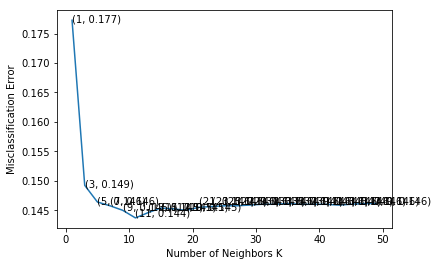

the misclassification error for each k value is :  [0.177 0.149 0.146 0.146 0.145 0.144 0.145 0.145 0.145 0.145 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146]


In [19]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts, Y, test_size=0.3, random_state=42)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [20]:
print(cv_scores)

[0.822745791005144, 0.8507716535340771, 0.8535989233054879, 0.8542412659786789, 0.8550119800554574, 0.8562979883717695, 0.8553984100160894, 0.8546275317891094, 0.8547560664934795, 0.8550129709025993, 0.8544989970847391, 0.854370462380369, 0.8542419276759988, 0.8542419276759988, 0.8541133929716287, 0.8539848582672585, 0.8539846928429284, 0.8538563231381788, 0.8539846928429284, 0.8539846928429284, 0.8539846928429284, 0.854113062547678, 0.8539845278433079, 0.8538559931389378, 0.8538559931389378]


In [22]:
# ============================== KNN with k = optimal_k ===============================================
from sklearn.metrics import confusion_matrix
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)


# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
print("Confusion matrix is:")
confusion_matrix(y_test, pred, labels=None, sample_weight=None)


The accuracy of the knn classifier for k = 11 is 84.557721%
Confusion matrix is:


array([[   6,  510],
       [   5, 2814]], dtype=int64)

Observation: We found that K=11 is the optimal value. And accuracy on the test dataset is 84.557721%

# TF-IDF

In [23]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
#print(final_tf_idf)


In [24]:
final_tf_idf.get_shape()
#print(final_tf_idf)

(11115, 258875)

In [25]:
features = tf_idf_vect.get_feature_names()
len(features)
#print(features)
features[200:210]


['absolut astound',
 'absolut aw',
 'absolut awesom',
 'absolut balanc',
 'absolut beauti',
 'absolut best',
 'absolut bore',
 'absolut buy',
 'absolut cant',
 'absolut certain']

In [26]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)


The optimal number of neighbors is 9.


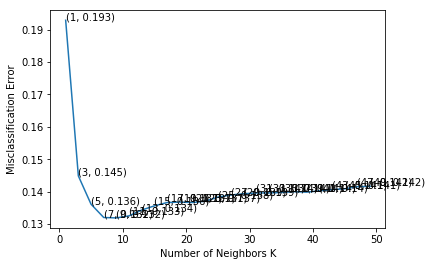

the misclassification error for each k value is :  [0.193 0.145 0.136 0.132 0.132 0.133 0.134 0.136 0.137 0.137 0.137 0.137
 0.138 0.139 0.139 0.14  0.14  0.14  0.14  0.14  0.14  0.141 0.141 0.142
 0.142]


In [27]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_tf_idf, Y, test_size=0.3, random_state=42)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [28]:
print(cv_scores)

[0.8070667012176298, 0.8551398526377983, 0.8638820339014378, 0.867994814017333, 0.8681228528734228, 0.8674788589298986, 0.8656797022185382, 0.8643943551748364, 0.863366077539875, 0.8632373782605937, 0.863365747540634, 0.8629808038507149, 0.8616957863815446, 0.861053113284403, 0.8606676741709129, 0.8604104393378428, 0.8604106043374633, 0.8602819046334726, 0.8600251656486828, 0.8601537003530529, 0.8597679308156124, 0.8593824917021223, 0.859125422293382, 0.8584827483468217, 0.858354048642831]


In [29]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
print("Confusion matrix is:")
confusion_matrix(y_test, pred, labels=None, sample_weight=None)


The accuracy of the knn classifier for k = 9 is 85.937031%
Confusion matrix is:


array([[  73,  443],
       [  26, 2793]], dtype=int64)

Observation: We found that K=9 is the optimal value. And accuracy on the test dataset is 85.937031%

#  Word2Vec

In [30]:
# Using Google News Word2Vectors
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('amazon-fine-food-reviews/GoogleNews-vectors-negative300.bin', binary=True)



C:\Users\Swapnanil\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [31]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    #print(sent)
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [32]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
print(w2v_model)


Word2Vec(vocab=6763, size=50, alpha=0.025)


#  Avg W2V, TFIDF-W2V

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
#print(sent_vectors[0])

11115
50



The optimal number of neighbors is 19.


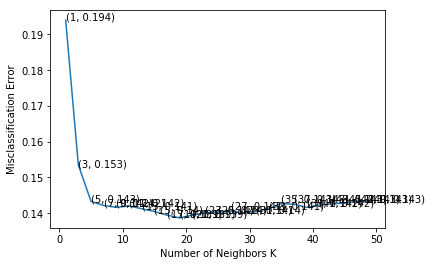

the misclassification error for each k value is :  [0.194 0.153 0.143 0.142 0.142 0.142 0.141 0.14  0.139 0.139 0.139 0.14
 0.14  0.141 0.14  0.14  0.141 0.143 0.143 0.142 0.142 0.143 0.143 0.143
 0.143]


In [34]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(sent_vectors, Y, test_size=0.3, random_state=42)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [35]:
print(cv_scores)

[0.8060382547606627, 0.8465293444689943, 0.8566824328157328, 0.8578400735508425, 0.8583542123683232, 0.8579686086799221, 0.8587399819057635, 0.8595108601327437, 0.8605394681916556, 0.8613100164193946, 0.8605383127696026, 0.8598956388230423, 0.8596389002629617, 0.859381665854601, 0.8598958046720817, 0.8595103655585916, 0.8587393227567006, 0.857325606008249, 0.8574541402879097, 0.8583538836432105, 0.8577112101213595, 0.8573256055835395, 0.8571972363034993, 0.8566829324863982, 0.8565545627816485]


In [36]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
print("Confusion matrix is:")
confusion_matrix(y_test, pred, labels=None, sample_weight=None)


The accuracy of the knn classifier for k = 19 is 85.277361%
Confusion matrix is:


array([[  39,  477],
       [  14, 2805]], dtype=int64)

Observation: We found that K=19 is the optimal value. And accuracy on the test dataset is 85.277361%

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [ ]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(tfidf_sent_vectors, Y, test_size=0.3, random_state=42)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [ ]:
print(cv_scores)

In [ ]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
print("Confusion matrix is:")
confusion_matrix(y_test, pred, labels=None, sample_weight=None)

Observation: We found that K=23 is the optimal value. And accuracy on the test dataset is 85.697151%